Digits dataset loaded.
Training samples: 1437, Test samples: 360

PART A: RANDOM FOREST
Best RF params: {'max_depth': 10, 'n_estimators': 200}
RF Accuracy: 0.9722
OOB Error: 0.0278
RF Train time: 0.973s
RF Predict time: 0.023s

PART B: ADABOOST
Best AdaBoost params: {'learning_rate': 1.0, 'n_estimators': 200}
AdaBoost Accuracy: 0.8639
AdaBoost Train time: 0.928s
AdaBoost Predict time: 0.052s


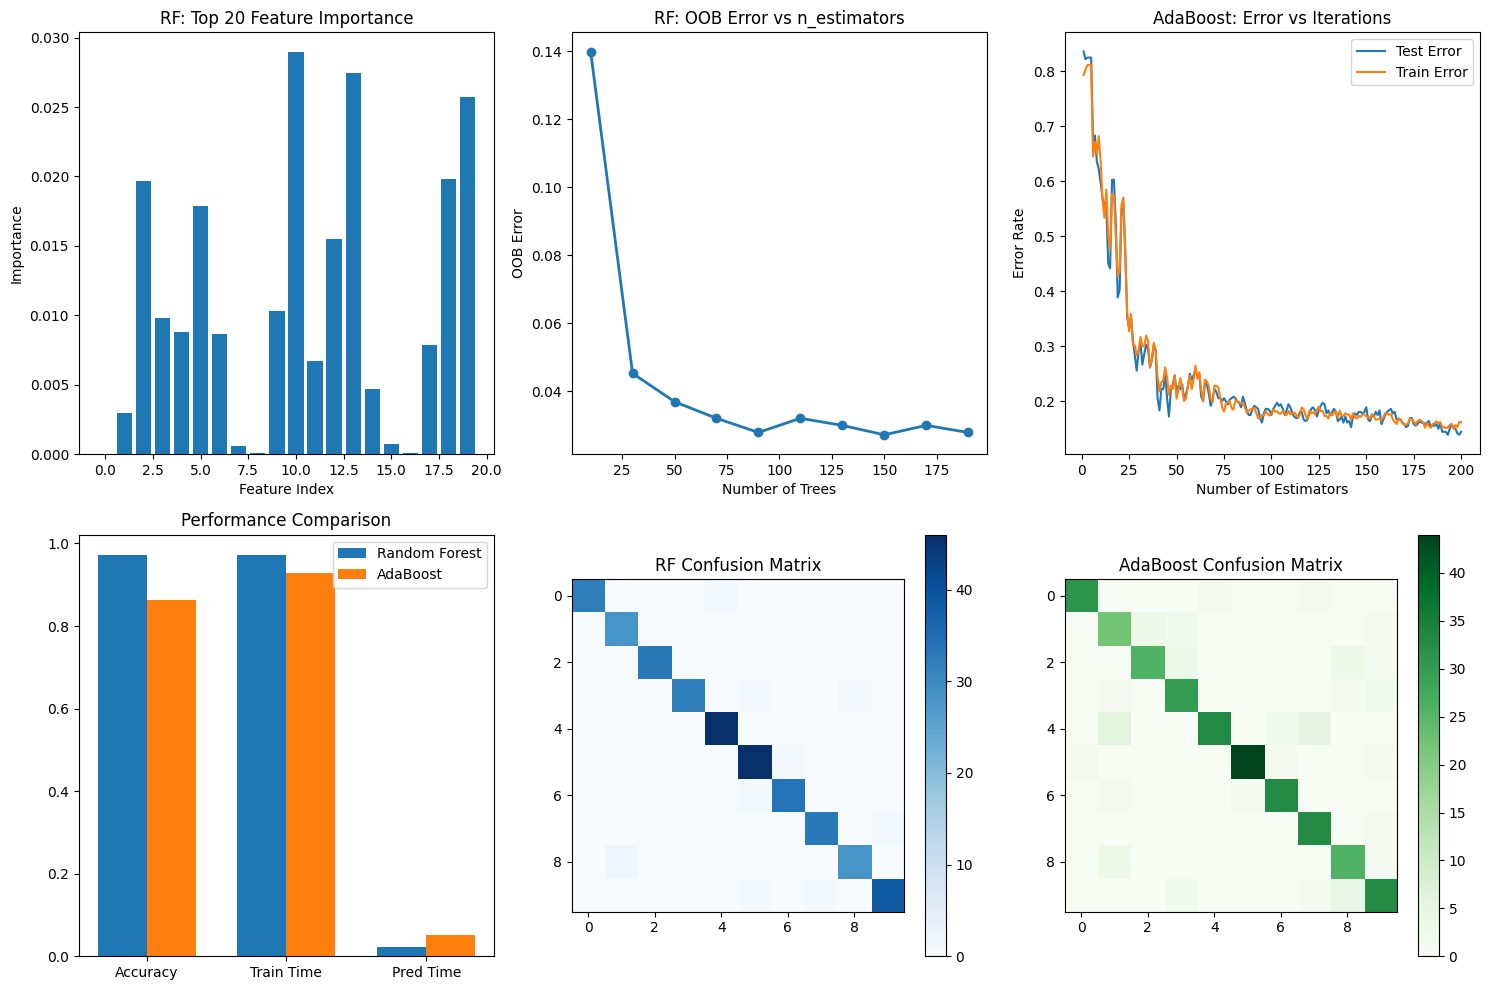


COMPARISON TABLE
Metric                   Random Forest       AdaBoost            
------------------------------------------------------------
Accuracy                 0.9722              0.8639              
Training Time (s)        0.973               0.928               
Prediction Time (s)      0.023               0.052               
OOB/Test Error           0.0278              0.1361              
------------------------------------------------------------


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import time
import warnings
warnings.filterwarnings("ignore")

digits = load_digits()
X, y = digits.data, digits.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Digits dataset loaded.")
print(f"Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")

print("\n" + "="*50 + "\nPART A: RANDOM FOREST\n" + "="*50)

rf_params = {
    "n_estimators": [50, 100, 200],
    "max_depth": [10, 20, None]
}

rf_grid = GridSearchCV(
    RandomForestClassifier(oob_score=True, random_state=42),
    rf_params,
    cv=3,
    n_jobs=-1
)

rf_grid.fit(X_train, y_train)
rf = rf_grid.best_estimator_

start_time = time.time()
rf.fit(X_train, y_train)
rf_train_time = time.time() - start_time

start_time = time.time()
y_pred_rf = rf.predict(X_test)
rf_pred_time = time.time() - start_time

rf_accuracy = accuracy_score(y_test, y_pred_rf)

print(f"Best RF params: {rf_grid.best_params_}")
print(f"RF Accuracy: {rf_accuracy:.4f}")
print(f"OOB Error: {1 - rf.oob_score_:.4f}")
print(f"RF Train time: {rf_train_time:.3f}s")
print(f"RF Predict time: {rf_pred_time:.3f}s")

print("\n" + "="*50 + "\nPART B: ADABOOST\n" + "="*50)

base_dt = DecisionTreeClassifier(max_depth=1, random_state=42)

ada_params = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.1, 0.5, 1.0]
}

ada_grid = GridSearchCV(
    AdaBoostClassifier(estimator=base_dt, random_state=42),
    ada_params,
    cv=3,
    n_jobs=-1
)

ada_grid.fit(X_train, y_train)
ada = ada_grid.best_estimator_

start_time = time.time()
ada.fit(X_train, y_train)
ada_train_time = time.time() - start_time

start_time = time.time()
y_pred_ada = ada.predict(X_test)
ada_pred_time = time.time() - start_time

ada_accuracy = accuracy_score(y_test, y_pred_ada)

print(f"Best AdaBoost params: {ada_grid.best_params_}")
print(f"AdaBoost Accuracy: {ada_accuracy:.4f}")
print(f"AdaBoost Train time: {ada_train_time:.3f}s")
print(f"AdaBoost Predict time: {ada_pred_time:.3f}s")

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].bar(range(20), rf.feature_importances_[:20])
axes[0, 0].set_title("RF: Top 20 Feature Importance")
axes[0, 0].set_xlabel("Feature Index")
axes[0, 0].set_ylabel("Importance")

oob_errors = []
estimators_range = range(10, 201, 20)

for n in estimators_range:
    rf_temp = RandomForestClassifier(
        n_estimators=n,
        oob_score=True,
        random_state=42,
        n_jobs=-1
    )
    rf_temp.fit(X_train, y_train)
    oob_errors.append(1 - rf_temp.oob_score_)

axes[0, 1].plot(estimators_range, oob_errors, "o-", linewidth=2)
axes[0, 1].set_title("RF: OOB Error vs n_estimators")
axes[0, 1].set_xlabel("Number of Trees")
axes[0, 1].set_ylabel("OOB Error")

test_errors = []
train_errors = []

ada_temp = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=200,
    learning_rate=0.5,
    random_state=42
)

ada_temp.fit(X_train, y_train)

for y_pred in ada_temp.staged_predict(X_test):
    test_errors.append(1 - accuracy_score(y_test, y_pred))

for y_pred in ada_temp.staged_predict(X_train):
    train_errors.append(1 - accuracy_score(y_train, y_pred))

axes[0, 2].plot(range(1, 201), test_errors, label="Test Error")
axes[0, 2].plot(range(1, 201), train_errors, label="Train Error")
axes[0, 2].set_title("AdaBoost: Error vs Iterations")
axes[0, 2].set_xlabel("Number of Estimators")
axes[0, 2].set_ylabel("Error Rate")
axes[0, 2].legend()

metrics = ["Accuracy", "Train Time", "Pred Time"]
rf_vals = [rf_accuracy, rf_train_time, rf_pred_time]
ada_vals = [ada_accuracy, ada_train_time, ada_pred_time]

x = np.arange(len(metrics))
width = 0.35

bars1 = axes[1, 0].bar(x - width/2, rf_vals, width, label="Random Forest")
bars2 = axes[1, 0].bar(x + width/2, ada_vals, width, label="AdaBoost")

axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(metrics)
axes[1, 0].set_title("Performance Comparison")
axes[1, 0].legend()

cm_rf = confusion_matrix(y_test, y_pred_rf)
im1 = axes[1, 1].imshow(cm_rf, cmap="Blues")
axes[1, 1].set_title("RF Confusion Matrix")
plt.colorbar(im1, ax=axes[1, 1])

cm_ada = confusion_matrix(y_test, y_pred_ada)
im2 = axes[1, 2].imshow(cm_ada, cmap="Greens")
axes[1, 2].set_title("AdaBoost Confusion Matrix")
plt.colorbar(im2, ax=axes[1, 2])

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("COMPARISON TABLE")
print("="*60)
print(f"{'Metric':<25}{'Random Forest':<20}{'AdaBoost':<20}")
print("-"*60)
print(f"{'Accuracy':<25}{rf_accuracy:<20.4f}{ada_accuracy:<20.4f}")
print(f"{'Training Time (s)':<25}{rf_train_time:<20.3f}{ada_train_time:<20.3f}")
print(f"{'Prediction Time (s)':<25}{rf_pred_time:<20.3f}{ada_pred_time:<20.3f}")
print(f"{'OOB/Test Error':<25}{1-rf.oob_score_:<20.4f}{1-ada_accuracy:<20.4f}")
print("-"*60)


Dataset loaded successfully.

=== Gradient Boosting ===
Best GB Params: {'learning_rate': np.float64(0.4262213204002109), 'max_depth': 2, 'n_estimators': 179}
Gradient Boosting Accuracy: 0.9805555555555555

=== Stacking Ensemble ===
Stacking Accuracy: 0.9861111111111112

=== Bootstrap Effect in Random Forest ===
Accuracy with Bootstrap: 0.9694444444444444
Accuracy without Bootstrap: 0.9777777777777777

=== Feature Importance Comparison ===


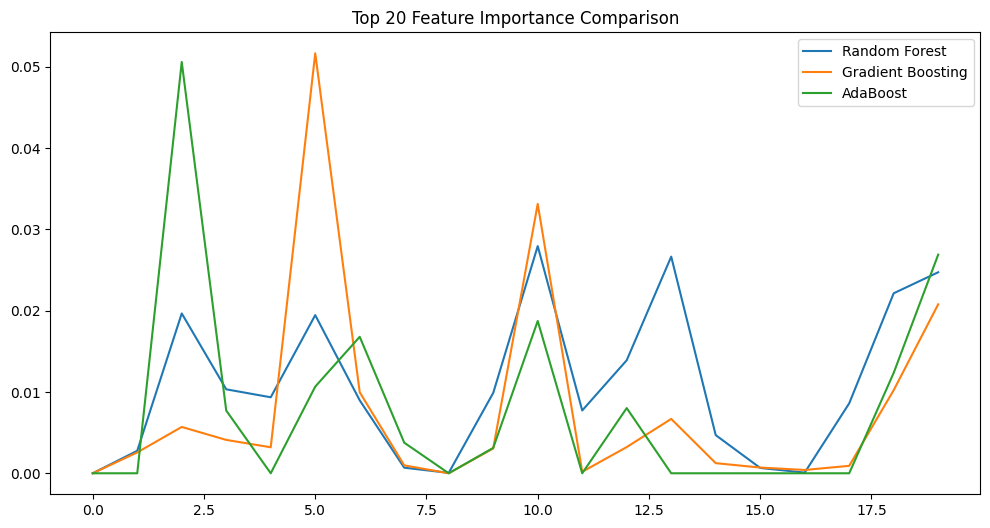


FINAL MODEL COMPARISON
Gradient Boosting Accuracy:         0.9806
Stacking Accuracy:                  0.9861
RF (Bootstrap=True):                0.9694
RF (Bootstrap=False):               0.9778


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    StackingClassifier
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from scipy.stats import randint, uniform
import warnings
warnings.filterwarnings("ignore")


digits = load_digits()
X, y = digits.data, digits.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Dataset loaded successfully.")


print("\n=== Gradient Boosting ===")

gb = GradientBoostingClassifier(random_state=42)

gb_params = {
    "n_estimators": randint(50, 300),
    "learning_rate": uniform(0.01, 0.5),
    "max_depth": randint(1, 5)
}

gb_random = RandomizedSearchCV(
    gb,
    gb_params,
    n_iter=15,
    cv=3,
    n_jobs=-1,
    random_state=42
)

gb_random.fit(X_train, y_train)
gb_best = gb_random.best_estimator_

y_pred_gb = gb_best.predict(X_test)
gb_accuracy = accuracy_score(y_test, y_pred_gb)

print("Best GB Params:", gb_random.best_params_)
print("Gradient Boosting Accuracy:", gb_accuracy)


print("\n=== Stacking Ensemble ===")

base_learners = [
    ("rf", RandomForestClassifier(n_estimators=100, random_state=42)),
    ("svm", SVC(probability=True, random_state=42)),
    ("dt", DecisionTreeClassifier(max_depth=5, random_state=42))
]

stack = StackingClassifier(
    estimators=base_learners,
    final_estimator=LogisticRegression(max_iter=1000),
    n_jobs=-1
)

stack.fit(X_train, y_train)
y_pred_stack = stack.predict(X_test)
stack_accuracy = accuracy_score(y_test, y_pred_stack)

print("Stacking Accuracy:", stack_accuracy)

print("\n=== Bootstrap Effect in Random Forest ===")

rf_bootstrap = RandomForestClassifier(
    n_estimators=200,
    bootstrap=True,
    random_state=42
)

rf_no_bootstrap = RandomForestClassifier(
    n_estimators=200,
    bootstrap=False,
    random_state=42
)

rf_bootstrap.fit(X_train, y_train)
rf_no_bootstrap.fit(X_train, y_train)

acc_bootstrap = accuracy_score(y_test, rf_bootstrap.predict(X_test))
acc_no_bootstrap = accuracy_score(y_test, rf_no_bootstrap.predict(X_test))

print("Accuracy with Bootstrap:", acc_bootstrap)
print("Accuracy without Bootstrap:", acc_no_bootstrap)


print("\n=== Feature Importance Comparison ===")

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=200,
    random_state=42
)
ada.fit(X_train, y_train)

importances_rf = rf.feature_importances_
importances_gb = gb_best.feature_importances_
importances_ada = ada.feature_importances_


plt.figure(figsize=(12, 6))
plt.plot(importances_rf[:20], label="Random Forest")
plt.plot(importances_gb[:20], label="Gradient Boosting")
plt.plot(importances_ada[:20], label="AdaBoost")
plt.title("Top 20 Feature Importance Comparison")
plt.legend()
plt.show()



print("\n" + "="*50)
print("FINAL MODEL COMPARISON")
print("="*50)

print(f"{'Gradient Boosting Accuracy:':35} {gb_accuracy:.4f}")
print(f"{'Stacking Accuracy:':35} {stack_accuracy:.4f}")
print(f"{'RF (Bootstrap=True):':35} {acc_bootstrap:.4f}")
print(f"{'RF (Bootstrap=False):':35} {acc_no_bootstrap:.4f}")
print("="*50)